In [1]:
import sqlite3 as sql
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import plotly.express as px

In [2]:
db = 'chinook.db'

In [3]:
def run_query (q):
    with sql.connect(db) as conn:
        return pd.read_sql_query(q,conn)

## Genre Analysis for Album Selection : Identifying Top-Selling Genres in USA 

##### Chinook record store wants to select three albums to add from a list of four new artists, each belonging to different genres. The genres include Hip-Hop, Punk, Pop, and Blues. The record label focuses on US artists and plans to advertise in the USA.

To decide which album to choose, we need to find out which genres are most popular in USA. We'll do this by querying the database to see which genres sell the most tracksin the USA. Based onthis info, we'll make recommendations for the three artists whose album chinook should purchase.

In [6]:
q = """ 
WITH usa_tracks AS
    (
    SELECT t.genre_id AS genre_id, il.invoice_line_id 
        FROM track as t
    INNER JOIN invoice_line as il ON il.track_id=t.track_id 
    INNER JOIN invoice as i ON i.invoice_id = il.invoice_id 
    WHERE i.billing_country= 'USA'
    )
    
SELECT g.name genre_name,
        COUNT (usa.genre_id) num_purchases,
        ROUND ((CAST(COUNT(usa.genre_id) AS FLOAT)/ (SELECT COUNT(genre_id)
                                    FROM usa_tracks)) *100,2) AS percentage_sold
                                    
FROM usa_tracks AS usa 
INNER JOIN genre as g ON g.genre_id= usa.genre_id

GROUP BY g.name 
ORDER BY num_purchases DESC """

In [7]:
df = run_query(q)
df

,genre_name,num_purchases,percentage_sold
0,Rock,561,53.38
1,Alternative & Punk,130,12.37
2,Metal,124,11.80
3,R&B/Soul,53,5.04
4,Blues,36,3.43
5,Alternative,35,3.33
6,Pop,22,2.09
7,Latin,22,2.09
8,Hip Hop/Rap,20,1.90
9,Jazz,14,1.33


C:\Users\hp\AppData\Local\Temp\ipykernel_12332\739999180.py:19: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(df['genre_name'], fontsize=10.5, color='grey')


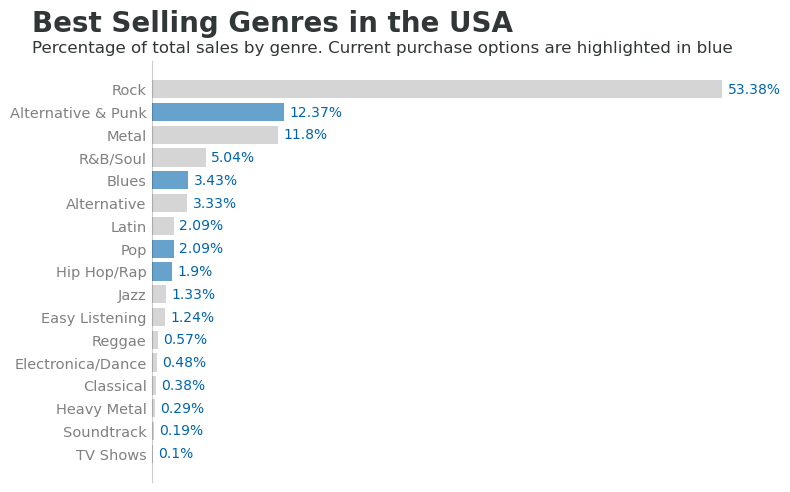

In [10]:
import matplotlib.pyplot as plt

# Sorting the DataFrame by percentage sold
df = df.sort_values(by='percentage_sold')

# Creating a color map to identify key albums of interest
album_options = ['Hip Hop/Rap', 'Alternative & Punk', 'Blues', 'Pop']
cmap = df['genre_name'].apply(lambda x: '#0064AB' if x in album_options else '#BABABA')

# Creating the bar plot
fig, ax = plt.subplots(figsize=(8, 5)) # Adjusted figsize
bars = ax.barh(df['genre_name'], df['percentage_sold'], height=0.8, color=cmap, alpha=0.6)

# Adding text and adjusting width of bars
for bar, percentage in zip(bars, df['percentage_sold']):
    ax.text(bar.get_width()+0.5, bar.get_y() + bar.get_height()/2, f'{percentage}%', va='center', ha='left', fontsize=10, color='#0064AB')

# Customizing axes and Layout
ax.set_yticklabels(df['genre_name'], fontsize=10.5, color='grey')
ax.set_xticks([])
plt.text(-0.2, 1.07, 'Best Selling Genres in the USA', fontsize=20, fontweight='bold', color='#313636', transform=plt.gca().transAxes)
plt.text(-0.2, 1.02, 'Percentage of total sales by genre. Current purchase options are highlighted in blue', fontsize=12, color='#313636', transform=plt.gca().transAxes)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)

# Adjusting Left spine opacity
ax.spines['left'].set_color('#000000')  
ax.spines['left'].set_alpha(0.2)        

# Removing y-axis tick parameters
ax.tick_params(axis='y', which='both', length=0)

plt.tight_layout()
plt.show()


### Results

>Based on the genre sales pattern in the USA. Chinook should select these options from the list of available albums.
>- Punk: Red Tone
>- Blues: Slim Jim Bites.
>- Pop: Meteor and the Girls

>It's worth noting that these three genres only make up 17% of total sales. To maximize profitability, the company should be on the lookout for Rock songs since they account for 53% of sales in the US market.

## Employee Sales Performance Analysis

#### The Situation

After an initial purchase, each Chinook customer is assigned to a sales support agent. The company asked us to analyze purchases from customers belonging to each sales agent. They want to know if some agents are performing better or worse than others.

#### Analysis

To answer this question, we need to extract the names of the sales executives, their hire dates, the number of accounts they handle, and the total purchases made by these accounts. We will also compute the average sales for each account that the sales executives manage.

In [11]:
q = """
        WITH t1 AS (SELECT em.first_name || ' ' || em.last_name AS sales_rep_name,
                            em.hire_date,
                            COUNT(cu.customer_id) AS num_invoices,
                            CAST (SUM(iv.total) AS Integer) AS total_sales
                    FROM employee em 
                    JOIN customer cu
                        ON em.employee_id = cu.support_rep_id 
                    JOIN invoice iv
                        ON iv.customer_id= cu.customer_id
                    GROUP BY 1
                    ORDER BY 4 DESC)
                    
        SELECT *,
                ROUND (CAST(total_sales AS Float) / num_invoices, 2)
                AS sales_per_customer
            FROM t1;
"""

In [12]:
df = run_query(q)
df

,sales_rep_name,hire_date,num_invoices,total_sales,sales_per_customer
0,Jane Peacock,2017-04-01 00:00:00,212,1731,8.17
1,Margaret Park,2017-05-03 00:00:00,214,1584,7.40
2,Steve Johnson,2017-10-17 00:00:00,188,1393,7.41


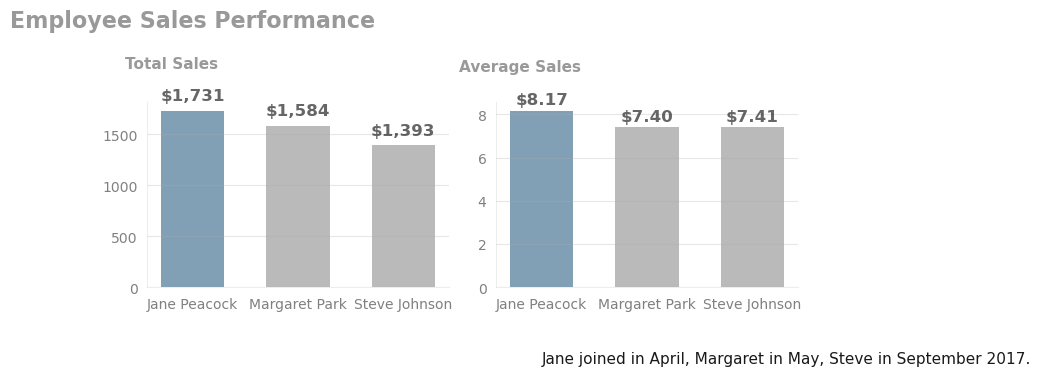

In [19]:
import matplotlib.pyplot as plt

# Data
sales_rep_name = df["sales_rep_name"].values
total_sales = df["total_sales"].values
sales_per_customer = df["sales_per_customer"].values

# Create subplots
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 8))

# Total sales chart
axes[0].bar(sales_rep_name, total_sales, color='#BABABA', width=0.6)
axes[0].bar(sales_rep_name[0], total_sales[0], color='#0064AB', alpha=0.3, width=0.6)

# Total sales chart Label
axes[0].text(x=-0.2, y=2150, s='Total Sales', size=11, fontweight='bold', alpha=0.4, ha='center')

# Total sales annotations
for sales, index in zip(total_sales, range(3)):
    axes[0].text(x=index, y=sales+100, s='${:,}'.format(sales), ha='center', fontweight='bold', alpha=0.6, size=12)

# Main chart title
axes[0].text(x=0, y=2550, s='Employee Sales Performance', size=16, fontweight='bold', alpha=0.4, ha='center')

# Average sales chart
axes[1].bar(sales_rep_name, sales_per_customer, color='#BABABA', width=0.6)
axes[1].bar(sales_rep_name[0], sales_per_customer[0], color='#0064AB', alpha=0.3, width=0.6)

# Average sales chart Label
axes[1].text(x=-0.2, y=10, s='Average Sales', size=11, fontweight='bold', alpha=0.4, ha='center')

# Average sales annotations
for sales, index in zip(sales_per_customer, range(3)):
    axes[1].text(x=index, y=sales+0.3, s='${:,.2f}'.format(sales), ha='center', fontweight='bold', alpha=0.6, size=12)

# Footnote
axes[1].text(x=0, y=-3.5, s='Jane joined in April, Margaret in May, Steve in September 2017.', size=11, alpha=0.9)

# Common attributes to both charts
for ax in axes:
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_color('#DDD')
    ax.spines['left'].set_alpha(0.5)
    ax.spines['bottom'].set_color('#DDD')
    ax.spines['bottom'].set_alpha(0.5)

    ax.tick_params(left=False, bottom=False, labelsize=10, labelcolor='grey')
    ax.grid(axis='y', linestyle='-', alpha=0.3)  # Corrected linestyle from '' to '-'

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


## Result

>• Of the three sales employees, Jane achieved the highest total sales of 1,731 dollars. Margaret Park comes second, and Steve occupies the last place with 1,393 dollars in sales. This difference in sales is understandable, considering that Jane and Margaret were employed about five months before Steve.  
>• Jane's average sales numbers support her leading position. She has achieved 8.17 dollars in sales per customer, the highest of the three employees. Steve also performs marginally better than Margaret despite the difference in their employment dates.

## Sales by Country

### The Situation

Chinook wants to understand how sales are distributed across different countries. The company intends to identify countries with growth potential and may even run advertising campaigns in these countries

### Analysis

To answer this question, we will write a query that collates data on purchases from different countries. For each country, we will include the total number of customers, total sales value, average sales per customer, and the average order value. Where a country has only one customer, we will collect it into an "Other" group:

In [24]:
q = """
       WITH 
    -- Collate the number of customers in each country
    t1 AS (
        SELECT 
            country, 
            COUNT(customer_id) AS num_customers
        FROM 
            customer
        GROUP BY 
            country
    ),
    
    -- Collate the total sales in each country
    t2 AS (
        SELECT 
            cu.country,
            ROUND(SUM(iv.total), 2) AS total_sales,
            COUNT(iv.invoice_id) AS num_sales
        FROM 
            customer cu
        JOIN 
            invoice iv ON cu.customer_id = iv.customer_id
        GROUP BY 
            cu.country
    ),

    -- Group countries with only 1 customer as 'Others'
    t3 AS (
        SELECT
            CASE
                WHEN t1.num_customers = 1 THEN 'Others'
                ELSE t1.country
            END AS countries,
            SUM(t1.num_customers) AS num_customers,
            SUM(t2.total_sales) AS total_sales,
            SUM(t2.num_sales) AS num_sales
        FROM
            t1
        JOIN
            t2 ON t1.country = t2.country
        GROUP BY 
            countries
    )

-- Calculate relevant sales metrics
SELECT 
    countries,
    num_customers,
    total_sales,
    ROUND(total_sales / num_sales, 2) AS avg_order_value,
    ROUND(total_sales / num_customers, 2) AS sales_per_customer
FROM (
    SELECT 
        *,
        CASE 
            WHEN countries = 'Others' THEN 1
            ELSE 0
        END AS sort
    FROM 
        t3
    )
ORDER BY 
    sort, 
    num_customers DESC;

    """

In [25]:
df = run_query(q)
df

,countries,num_customers,total_sales,avg_order_value,sales_per_customer
0,USA,13,1040.49,7.94,80.04
1,Canada,8,535.59,7.05,66.95
2,Brazil,5,427.68,7.01,85.54
3,France,5,389.07,7.78,77.81
4,Germany,4,334.62,8.16,83.66
5,United Kingdom,3,245.52,8.77,81.84
6,Czech Republic,2,273.24,9.11,136.62
7,India,2,183.15,8.72,91.58
8,Portugal,2,185.13,6.38,92.57
9,Others,15,1094.94,7.45,73.00


In [27]:
# Additional calculations
avg_cust_purchase = df['sales_per_customer'].mean()  # Corrected indexing of 'sales_per_customer'
print(avg_cust_purchase)
df['pcent_customer'] = round(100 * df['num_customers'] / df['num_customers'].sum(), 1)  # Corrected indexing of 'num_customers'
df['pcent_sales'] = round(100 * df['total_sales'] / df['total_sales'].sum(), 1)  # Corrected indexing of 'total_sales'
df['cust_purchase_diff'] = round(100 * (df['sales_per_customer'] - avg_cust_purchase) / avg_cust_purchase, 2)  # Corrected the placement of the parenthesis and removed an extra comma


86.96099999999998


In [28]:
df

,countries,num_customers,total_sales,avg_order_value,sales_per_customer,pcent_customer,pcent_sales,cust_purchase_diff
0,USA,13,1040.49,7.94,80.04,22.0,22.1,-7.96
1,Canada,8,535.59,7.05,66.95,13.6,11.4,-23.01
2,Brazil,5,427.68,7.01,85.54,8.5,9.1,-1.63
3,France,5,389.07,7.78,77.81,8.5,8.3,-10.52
4,Germany,4,334.62,8.16,83.66,6.8,7.1,-3.80
5,United Kingdom,3,245.52,8.77,81.84,5.1,5.2,-5.89
6,Czech Republic,2,273.24,9.11,136.62,3.4,5.8,57.10
7,India,2,183.15,8.72,91.58,3.4,3.9,5.31
8,Portugal,2,185.13,6.38,92.57,3.4,3.9,6.45
9,Others,15,1094.94,7.45,73.00,25.4,23.2,-16.05


In [29]:
 (136.62 - 86.96099999999998)

49.65900000000002

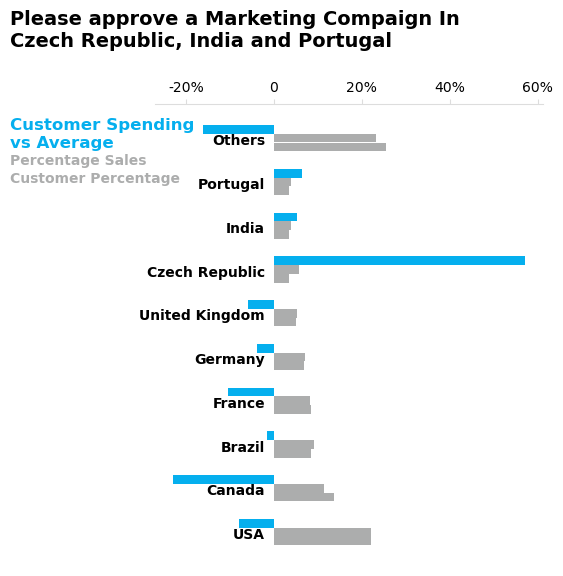

In [34]:
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming df contains columns: countries, pcent_customer, pcent_sales, cust_purchase_diff
y_labs = df['countries'].values
y_axes = np.arange(df['countries'].size)
fig = plt.figure(figsize=(5, 6))

plt.barh(y_axes - 0.3, df['pcent_customer'], height=0.2, color='#acadad')
plt.barh(y_axes - 0.1, df['pcent_sales'], height=0.2, color='#acadad')
plt.barh(y_axes + 0.1, df['cust_purchase_diff'], height=0.2, color='#05afee')

color_map = ['' for _ in range(len(y_labs))]  
for i, label in enumerate(y_labs):
    if color_map[i] == 'Yes':
        plt.text(x=-2, y=y_axes[i] - 0.25, s=label, ha='right', color='#05afee')
    else:
        plt.text(x=-2, y=y_axes[i] - 0.25, s=label, ha='right', fontweight='bold')

plt.text(x=-60, y=8.7, s='Customer Spending\nvs Average', color='#05afee', size=12, fontweight='bold')
plt.text(x=-60, y=8.3, s='Percentage Sales', color='#acadad', fontweight='bold')
plt.text(x=-60, y=7.9, s='Customer Percentage', color='#acadad', fontweight='bold')
plt.text(x=-60, y=11, s='Please approve a Marketing Compaign In\nCzech Republic, India and Portugal', size=14, fontweight='bold')

for ax in fig.get_axes():
    plt.sca(ax)
    sns.despine(left=True, bottom=True, top=False)
    ax.tick_params(left=False, bottom=False, color='#DDD')
    ax.xaxis.set_ticks_position('top')
    ax.spines['top'].set_color('#DDD')
    plt.yticks([])
    plt.xticks([-20, 0, 20, 40, 60], ['-20%', '0', '20%', '40%', '60%'], size=10)

plt.show()


## Result:

>- The Majority of Chinook sales arise from US and Canada. These two countries dominate in customer base as well as sales. However,customers spend lesser per invoice in these countries.
>- Although the Czech Republic, Portugal, and India record fewer customers and lesser sales values, customers spend more per invoice than in other countries. To increase revenue from these three markets, Chinook could run marketing campaigns to expand its customer base.

Since the data from each country are relatively few, the initial marketing campaigns should be small. They should aim to collect and analyze customer data so that the right trends are confidently identified

## How Many Tracks Never Sell?

To answer this question, we will have to distriguish between the entire inventory of tracks in the track table and the distinct instances of tracks from the invoice_line table.

In [37]:
q = """WITH all_and_purchased AS
(
    SELECT 
        t.track_id AS all_tracks,
        il.track_id AS purchased_tracks
    FROM 
        track AS t 
    LEFT JOIN 
        invoice_line AS il ON t.track_id = il.track_id
)
SELECT 
    COUNT(DISTINCT a.all_tracks) AS total_tracks,
    COUNT(DISTINCT a.purchased_tracks) AS tracks_purchased,
    COUNT(DISTINCT a.all_tracks) - COUNT(DISTINCT a.purchased_tracks) AS not_purchased,
    ROUND(COUNT(DISTINCT a.purchased_tracks) / NULLIF(CAST(COUNT(DISTINCT a.all_tracks) AS float), 0), 2) AS percent_purchased
FROM 
    all_and_purchased AS a;
"""

In [38]:
purchased = run_query(q)
purchased

,total_tracks,tracks_purchased,not_purchased,percent_purchased
0,3503,1806,1697,0.52


In [39]:
purchased = purchased. T
purchased = purchased.iloc[[1,2],0]
purchased_list = purchased.tolist()

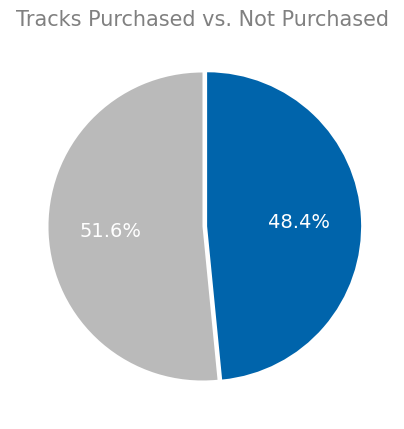

In [40]:
# Plot
plt.pie(purchased_list,
        explode=(0, 0.03),
        startangle=90,
        autopct='%1.1f%%',  # Corrected the formatting
        textprops={'fontsize': 14, 'color': 'white'}, 
        colors=('#BABABA', '#0064AB'))  # Corrected colors syntax

# Plot Aesthetics
plt.title('Tracks Purchased vs. Not Purchased', fontsize=15, color='gray')  # Corrected color syntax
fig = plt.gcf()  # Corrected missing '=' sign
fig.set_size_inches(5, 5)  # Corrected missing '.' between 'plt' and 'gcf'
plt.show()


### OBSERVATION:

Suprisingly, almost half of the track inventory at Chinook has not sold. Lets take a look at the bottom performers and see of we can learn more:

In [49]:
q = """
SELECT ar.name AS artist_name, 
       g.name AS genre, 
       COUNT(il.track_id) AS units_sold
FROM track AS t
LEFT JOIN invoice_line AS il ON il.track_id = t.track_id
INNER JOIN album AS al ON al.album_id = t.album_id
INNER JOIN artist AS ar ON ar.artist_id = al.artist_id
INNER JOIN genre AS g ON g.genre_id = t.genre_id
GROUP BY artist_name, genre 
HAVING units_sold = 0
ORDER BY units_sold;
"""

In [50]:
run_query(q)

,artist_name,genre,units_sold
0,Aaron Copland & London Symphony Orchestra,Classical,0
1,Academy of St. Martin in the Fields Chamber En...,Classical,0
2,"Academy of St. Martin in the Fields, John Birc...",Classical,0
3,"Academy of St. Martin in the Fields, Sir Nevil...",Classical,0
4,Adrian Leaper & Doreen de Feis,Classical,0
...,...,...,...
75,Ton Koopman,Classical,0
76,Toquinho & Vinícius,Bossa Nova,0
77,Various Artists,Latin,0
78,Various Artists,Pop,0


### Observation:

74 artists have not sold any units, with most of these tracks belonging to the classical music genre.
Half of the company's inventory remains unsold, potentially tying up working capital without generating returns.
Depending on the payment arrangement with record labels, there are two scenarios to consider:

>1. If Chinook pays a fixed fee to host these tracks, it might be wise to focus on more popular genres and discontinue signing less successful artists.
>2. If Chinook pays the record label based on sales percentage, there is little downside to keeping the tracks in the store.

Regardless of the scenario, Chinook should explore ways to promote these low-selling artists. Suggestions could be integrated into the purchasing process or
displayed on the website's cart page to increase exposure

## Albums vs Individual Tracks

The Chinook store allows customers to buy music in two ways: either as a complete album or as individual tracks. However, customers cannot buy a full album and then add individual tracks to the same purchase unless they select each track manually. When customers purchase albums, they are charged the same price as if they had bought each track separately.

Management is contemplating a new purchasing approach to cut costs. Instead of buying every track from an album, they are considering purchasing only the most popular tracks from each album from record companies.

In [51]:
q = """WITH invoice_data AS (
    SELECT invoice_id, MIN(track_id) AS track_id FROM invoice_line
    GROUP BY invoice_id
),
Album_purchased AS (
    SELECT 
        invd.invoice_id,
        CASE
            WHEN (
                SELECT t2.track_id
                FROM track t1
                JOIN track t2 ON t1.album_id = t2.album_id
                WHERE t1.track_id = invd.track_id
                EXCEPT
                SELECT il.track_id FROM invoice_line il
                WHERE il.invoice_id = invd.invoice_id
            ) IS NULL
            AND (
                SELECT il.track_id FROM invoice_line il
                WHERE il.invoice_id = invd.invoice_id
                EXCEPT
                SELECT t2.track_id FROM track t1
                JOIN track t2 ON t1.album_id = t2.album_id
                WHERE t1.track_id = invd.track_id
            ) IS NULL
            THEN 'Yes' 
            ELSE 'No' 
        END AS Purchased_Album 
    FROM invoice_data invd
)
SELECT 
    Purchased_Album, 
    COUNT(invoice_id) AS no_of_invoices, 
    COUNT(invoice_id) * 100.0 / (SELECT COUNT(*) FROM Album_purchased) AS percent 
FROM Album_purchased
GROUP BY 1;
"""

In [52]:
run_query(q)

,Purchased_Album,no_of_invoices,percent
0,No,500,81.433225
1,Yes,114,18.566775


## Result:

Most purchases (81%) from the store are individual tracks. However, in about 19% of cases, customers buy entire albums, Chinook should be careful with purchasing only the most popular tracks since it risks losing revenue from customers who purchase entire albums.

# CONCLUSION & RECOMMENDATION:

Throughout this project, we've been helping a pretend company figure out how to make more money. We've looked at different situations they might face and given them advice on how to handle them.

>- First, when it comes to picking what kind of music to sell, we think the company should focus on genres that are really popular in the USA. So, they should consider making albums in styles like Hip-Hop, Punk, and Pop because those types of music seem to sell well. Also, since Rock music sells the most overall, it's a good idea for them to keep offering that too.

>- Next, we looked at how well the employees are doing. Jane Peacock is doing the best out of everyone. But even though Steve Johnson has lower sales right now, he's new to the team. So, with a bit more training and support, he could do even better.

>- Then, we checked out how sales are going in different countries. The USA and Canada have a lot of customers, but they don't spend as much each time they buy something. On the other hand, customers in places like the Czech Republic, India, and Portugal spend more per transaction. So, it might be a good idea to focus more on these countries with marketing to bring in even more customers.

>- Lastly, we talked about how Chinook sells individual songs versus whole albums. Right now, they mostly focus on selling popular songs individually. But some customers might prefer buying whole albums instead. So, before they change their strategy, it would be smart to ask customers what they think.

In summary, if Chinook listens to our advice and keeps up with what customers want, they can make their business better, make customers happier, and make more money in the long run.